# RNN - Forzen Dessert Monthly Sales Forecasting with LSTM

## Data

Info about this data set: https://fred.stlouisfed.org/series/IPN31152N


Units:  Index 2012=100, Not Seasonally Adjusted

Frequency:  Monthly

The industrial production (IP) index measures the real output of all relevant establishments located in the United States, regardless of their ownership, but not those located in U.S. territories.

NAICS = 31152

Source Code: IP.N31152.N

Suggested Citation:
Board of Governors of the Federal Reserve System (US), Industrial Production: Nondurable Goods: Ice cream and frozen dessert [IPN31152N], retrieved from FRED, Federal Reserve Bank of St. Louis; https://fred.stlouisfed.org/series/IPN31152N, November 16, 2019.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_csv('../Data/Frozen_Dessert_Production.csv', parse_dates=True, index_col='DATE')

In [3]:
df.head()

,IPN31152N
DATE,
1972-01-01,59.9622
1972-02-01,67.0605
1972-03-01,74.2350
1972-04-01,78.1120
1972-05-01,84.7636


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 573 entries, 1972-01-01 to 2019-09-01
Data columns (total 1 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   IPN31152N  573 non-null    float64
dtypes: float64(1)
memory usage: 9.0 KB


**Change the column name to Production**

In [5]:
df.columns=['Production']

In [6]:
df.head()

,Production
DATE,
1972-01-01,59.9622
1972-02-01,67.0605
1972-03-01,74.2350
1972-04-01,78.1120
1972-05-01,84.7636


--------

**Plot out the time series**

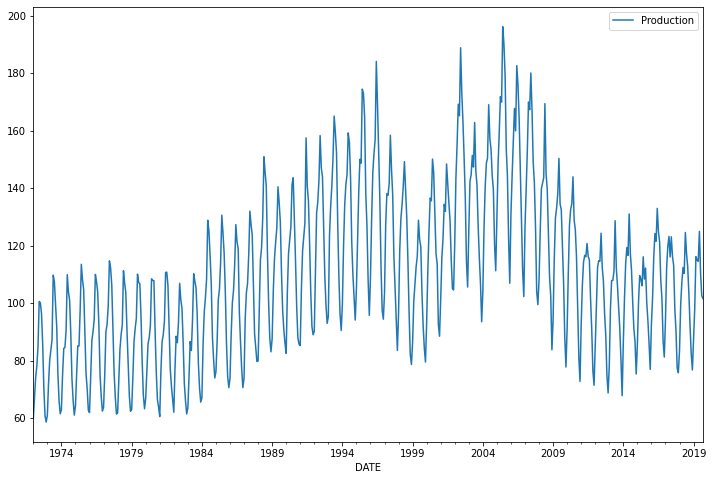

In [7]:
df.plot(figsize=(12,8));

-------

# Train Test Split

**check the length of the data set**

In [8]:
len(df)

573

**Split the data into a train/test split where the test set is the last 24 months of data.**

Based on the RMSE values, test_size is updated with 18 after comparing values.

In [37]:
test_size = 18

In [38]:
test_index_starting_point = len(df) - test_size
test_index_starting_point

555

In [39]:
train = df.iloc[:test_index_starting_point]
test = df.iloc[test_index_starting_point:]

In [40]:
train.shape, test.shape

((555, 1), (18, 1))

# Scale Data

**MinMaxScaler to scale the train and test sets into scaled versions.**

In [41]:
from sklearn.preprocessing import MinMaxScaler

In [42]:
scaler = MinMaxScaler()

In [43]:
scaled_train = scaler.fit_transform(train)
scaled_test = scaler.transform(test)

# Time Series Generator

**Setting minimum at least 18 to capture a full year seasonality.**

Updated to 12 as part of hypermeters tuning.

In [44]:
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

In [45]:
length = 12
batch_size = 1
n_features = 1

In [46]:
generator = TimeseriesGenerator(data=scaled_train, targets=scaled_train,
                                                   length=length, batch_size=batch_size)

In [47]:
# check the example first batch
generator[0]

(array([[[0.00947104],
         [0.06108982],
         [0.11326273],
         [0.14145625],
         [0.18982663],
         [0.30495972],
         [0.30154406],
         [0.27416065],
         [0.19736841],
         [0.08532665],
         [0.01561588],
         [0.        ]]]),
 array([[0.01774221]]))

# Create the Model

In [50]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM

In [51]:
model = Sequential()

model.add(LSTM(150, input_shape=(length, n_features), activation='relu'))

model.add(Dense(1))

model.compile(optimizer='adam', loss='mse')

In [52]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 150)               91200     
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 151       
Total params: 91,351
Trainable params: 91,351
Non-trainable params: 0
_________________________________________________________________


-----

**generator for the scaled test/validation set.** 

NOTE: Double check that batch length makes sense for the size of the test set.

In [53]:
validation_generator = TimeseriesGenerator(data=scaled_test, targets=scaled_test,
                                                                      length=length, batch_size=batch_size)

**EarlyStopping callback based on val_loss.**

In [24]:
from tensorflow.keras.callbacks import EarlyStopping

In [54]:
early_stopping = EarlyStopping(monitor='val_loss', patience=3, verbose=1)

-------

**Fit the model to the generator, let the EarlyStopping dictate the amount of epochs**

In [55]:
model.fit(generator,
             epochs = 20,
             validation_data = validation_generator,
             callbacks = [early_stopping],
             verbose = 1)

Epoch 1/20
543/543 [==============================] - 3s 6ms/step - loss: 0.0189 - val_loss: 0.0015
Epoch 2/20
543/543 [==============================] - 3s 5ms/step - loss: 0.0070 - val_loss: 0.0016
Epoch 3/20
543/543 [==============================] - 3s 5ms/step - loss: 0.0056 - val_loss: 0.0025
Epoch 4/20
543/543 [==============================] - 3s 5ms/step - loss: 0.0047 - val_loss: 0.0013
Epoch 5/20
543/543 [==============================] - 3s 6ms/step - loss: 0.0042 - val_loss: 0.0030
Epoch 6/20
543/543 [==============================] - 3s 5ms/step - loss: 0.0039 - val_loss: 0.0093
Epoch 7/20
543/543 [==============================] - 3s 5ms/step - loss: 0.0039 - val_loss: 0.0019
Epoch 00007: early stopping


**Plot the history of the loss that occured during training.**

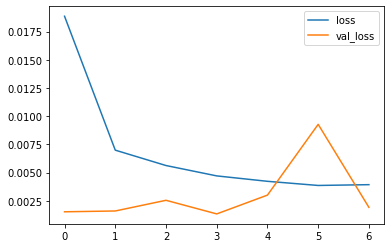

In [56]:
losses = pd.DataFrame(model.history.history)

losses.plot();

--------

# Evaluate on Test Data

**Forecast predictions for test data range (the last 12 months of the entire dataset)**

In [57]:
test_predictions = []

first_evaluation_batch = scaled_train[-length:]
current_batch = first_evaluation_batch.reshape((1, length, n_features))
print(current_batch, '\n')

for i in range(len(test)):
    current_prediction = model.predict(current_batch)[0]
    print(f'Loop{i} : {model.predict(current_batch)}')
    
    test_predictions.append(current_prediction)
    
    current_batch = np.append(current_batch[:, 1:, :], [[current_prediction]], axis=1)

[[[0.4695409 ]
  [0.41743926]
  [0.46851409]
  [0.41889656]
  [0.39641011]
  [0.28544533]
  [0.23134679]
  [0.13655347]
  [0.12472921]
  [0.18015997]
  [0.29691617]
  [0.35382169]]] 

Loop0 : [[0.3987229]]
Loop1 : [[0.42691177]]
Loop2 : [[0.44311166]]
Loop3 : [[0.43523705]]
Loop4 : [[0.39836907]]
Loop5 : [[0.33089137]]
Loop6 : [[0.26499456]]
Loop7 : [[0.20838332]]
Loop8 : [[0.19395341]]
Loop9 : [[0.22548862]]
Loop10 : [[0.28556544]]
Loop11 : [[0.33758324]]
Loop12 : [[0.38046044]]
Loop13 : [[0.41141927]]
Loop14 : [[0.4291212]]
Loop15 : [[0.42913604]]
Loop16 : [[0.4041291]]
Loop17 : [[0.3554139]]


### Inverse Transform the predictions

In [58]:
true_predictions = scaler.inverse_transform(test_predictions)

In [59]:
test['Predictions'] = true_predictions

<ipython-input-59-920b79c3c314>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['Predictions'] = true_predictions


In [60]:
test

,Production,Predictions
DATE,,
2018-04-01,112.4309,113.489739
2018-05-01,110.3544,117.366103
2018-06-01,124.5841,119.593812
2018-07-01,117.2215,118.510944
2018-08-01,112.6779,113.441085
2018-09-01,103.3118,104.161963
2018-10-01,92.1321,95.100236
2018-11-01,82.4347,87.315403
2018-12-01,76.7608,85.331090


**Plot the predictions versus the True test values.**

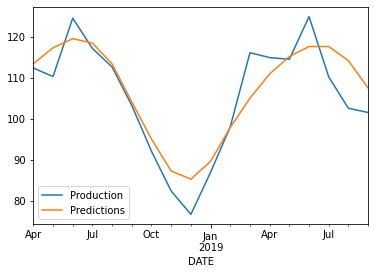

In [61]:
 test.plot();

### **RMSE**

#### method 1, using tensorflow keras metrics

In [62]:
from tensorflow.keras.metrics import RootMeanSquaredError

In [63]:
# method 1, using tensorflow keras metrics

m = RootMeanSquaredError()
m.update_state(test['Production'], test['Predictions'])
m.result().numpy()

5.8181276

####  method 2, using sklearn metrics

In [64]:
from sklearn.metrics import mean_squared_error

In [65]:
# method 2, using sklearn metrics

rmse = np.sqrt(mean_squared_error(test['Production'], test['Predictions']))
rmse

5.818127689241526

---------

# Retrain on Full dataset and Forecasting unknown future (next 12 months Sales)

In [91]:
# Scaling
full_scaler = MinMaxScaler()
scaled_full_data = full_scaler.fit_transform(df)

In [92]:
# Generator
length = 12
batch_size = 1

full_generator = TimeseriesGenerator(data=scaled_full_data, targets=scaled_full_data,
                                                            length=length,
                                                            batch_size=batch_size)

In [93]:
# Building Model
full_model = Sequential()

full_model.add(LSTM(150, input_shape = (length, n_features),activation='relu'))

full_model.add(Dense(1))

full_model.compile(optimizer='adam', loss='mse')

In [94]:
full_model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_5 (LSTM)                (None, 150)               91200     
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 151       
Total params: 91,351
Trainable params: 91,351
Non-trainable params: 0
_________________________________________________________________


In [95]:
# Train Model
full_model.fit(full_generator,
                      epochs=7,
                      verbose=1)

Epoch 1/7
561/561 [==============================] - 3s 5ms/step - loss: 0.0230
Epoch 2/7
561/561 [==============================] - 3s 5ms/step - loss: 0.0076
Epoch 3/7
561/561 [==============================] - 3s 5ms/step - loss: 0.0056
Epoch 4/7
561/561 [==============================] - 3s 6ms/step - loss: 0.0045
Epoch 5/7
561/561 [==============================] - 3s 5ms/step - loss: 0.0047
Epoch 6/7
561/561 [==============================] - 3s 6ms/step - loss: 0.0041
Epoch 7/7
561/561 [==============================] - 3s 5ms/step - loss: 0.0037


In [96]:
# check losses
losses = pd.DataFrame(full_model.history.history)

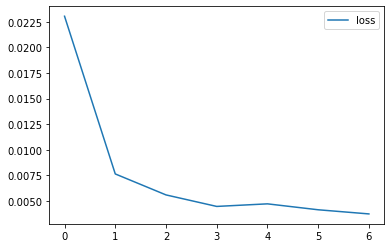

In [97]:
losses.plot();

In [98]:
# Forecasting the future
forecast = []
periods = 12

first_evaluation_batch = scaled_full_data[-length: ]
current_batch = first_evaluation_batch.reshape((1, length, n_features))

for i in range(periods):
    current_prediction = model.predict(current_batch)[0]
    
    forecast.append(current_prediction)
    
    current_batch = np.append(current_batch[:, 1:, :], [[current_prediction]], axis=1)

In [99]:
# Inverse Transform the predictions
forecast = full_scaler.inverse_transform(forecast)

In [100]:
# Create index for new timeseries
df.tail()

,Production
DATE,
2019-05-01,114.5613
2019-06-01,124.9605
2019-07-01,110.2632
2019-08-01,102.6085
2019-09-01,101.5866


In [101]:
forecast_indexes = pd.date_range(start='2019-10-01', periods=periods, freq='MS')

In [103]:
forecast_df = pd.DataFrame(data=forecast, index=forecast_indexes, columns=['Forecast'])

In [104]:
forecast_df

,Forecast
2019-10-01,93.417194
2019-11-01,88.772176
2019-12-01,88.538886
2020-01-01,93.823587
2020-02-01,101.941278
2020-03-01,108.675388
2020-04-01,112.726599
2020-05-01,116.112740
2020-06-01,117.343710
2020-07-01,114.091081


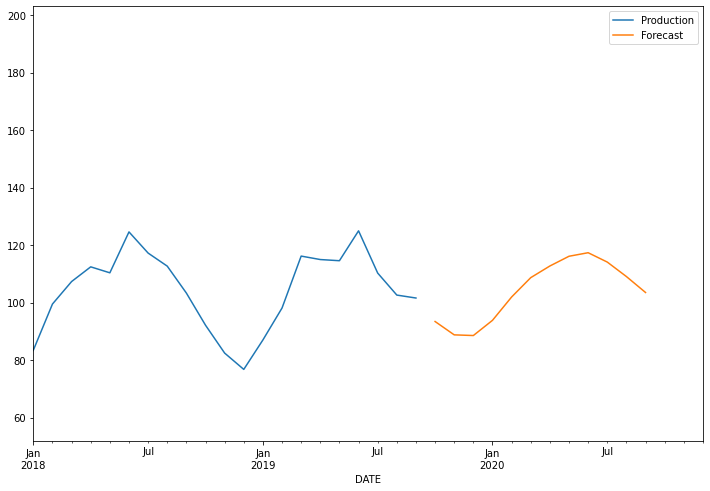

In [107]:
# Plot the data together with forecasted data
ax = df.plot()
forecast_df.plot(ax=ax, figsize=(12,8));
plt.xlim('2018-01-01', '2020-12-01');